# TCG thresholds as FC

This notebook investigates whether we can swap TCG thresholds for fractional cover.

In [5]:
import asyncio
from time import time
import itertools

import ipywidgets
import matplotlib.pyplot as plt
import numpy as np
import xarray
from skimage.filters import threshold_otsu
import datacube
from tqdm.notebook import tqdm
import sklearn.metrics

Set these parameters to change the plots at the end:

In [137]:
tile = '17,-39'
xlim = 1.70e6, 1.74e6
ylim = -3.84e6, -3.80e6
# Set the limits to None to show the whole tile.
# xlim = None
# ylim = None

In [6]:
%%bash
ls /g/data/r78/datacube_stats/TCW_stats/demo_tiles/gabrielle_workspace/output/

events
jobs
logs
LS_TCG_PC_0_-13_1986_2020_summary.tif
LS_TCG_PC_0_-13_1986_2020_summary.yaml
LS_TCG_PC_-10_-36_1986_2020_summary.tif
LS_TCG_PC_-10_-36_1986_2020_summary.yaml
LS_TCG_PC_11_-40_1986_2020_summary.tif
LS_TCG_PC_11_-40_1986_2020_summary.tif.aux.xml
LS_TCG_PC_11_-40_1986_2020_summary.yaml
LS_TCG_PC_12_-47_1986_2020_summary.tif
LS_TCG_PC_12_-47_1986_2020_summary.yaml
LS_TCG_PC_12_-48_1986_2020_summary.tif
LS_TCG_PC_12_-48_1986_2020_summary.tif.aux.xml
LS_TCG_PC_12_-48_1986_2020_summary.yaml
LS_TCG_PC_-13_-27_1986_2020_summary.tif
LS_TCG_PC_-13_-27_1986_2020_summary.yaml
LS_TCG_PC_14_-23_1986_2020_summary.tif
LS_TCG_PC_14_-23_1986_2020_summary.yaml
LS_TCG_PC_14_-35_1986_2020_summary.tif
LS_TCG_PC_14_-35_1986_2020_summary.yaml
LS_TCG_PC_14_-41_1986_2020_summary.tif
LS_TCG_PC_14_-41_1986_2020_summary.yaml
LS_TCG_PC_15_-22_1986_2020_summary.tif
LS_TCG_PC_15_-22_1986_2020_summary.yaml
LS_TCG_PC_-15_-36_1986_2020_summary.tif
LS_TCG_PC_-15_-36_1986_2020_summary.yaml
LS_TCG_PC_16_-34

Unload all python modules, if you experience any issues.


In [8]:
dc = datacube.Datacube(app='thresholds')

In [9]:
def get_tcw(tile_label):
    tif_path_base = "/g/data/r78/datacube_stats/TCW_stats/demo_tiles/gabrielle_workspace/output/LS_TCW_PC_{}_1986_2020_summary.tif"
    tif_path = tif_path_base.format(tile_label.replace(",", "_"))
    da = xarray.open_rasterio(tif_path)
    return da

def get_mrvbf(tile_label):
    mrvbf_path_base = (
        mrvbf_base_path
    ) = "/g/data/u46/wofs/confidence_albers/MrVBF/tiles/mrvbf_{}.nc"
    mrvbf_path = mrvbf_path_base.format(tile_label.replace(",", "_"))
    da = xarray.open_dataset(mrvbf_path)
    return da

def get_tcg(tile_label):
    tif_path_base = "/g/data/r78/datacube_stats/TCW_stats/demo_tiles/gabrielle_workspace/output/LS_TCG_PC_{}_1986_2020_summary.tif"
    tif_path = tif_path_base.format(tile_label.replace(",", "_"))
    da = xarray.open_rasterio(tif_path)
    return da

def get_fc(da):
    return dc.load('fc_percentile_albers_annual', time='2019', geopolygon=datacube.utils.geometry.Geometry(tcg.isel(band=1).geobox.extent))

In [60]:
tcg = get_tcg(tile)

In [61]:
fc = get_fc(tcg.isel(band=1))

In [143]:
proxies = {
    'PV50': fc.PV_PC_50.isel(time=0),
    'PV10': fc.PV_PC_90.isel(time=0),
}
green = tcg.isel(band=1)

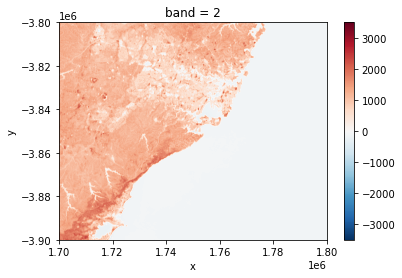

In [67]:
green.plot.imshow(interpolation='gaussian')

In [65]:
tcw_mask = get_tcw(tile).isel(band=2) > -600

First we replicate Gabrielle's wet vegetation mask, with TCW90 > -600 and TCG50 < 1000.

In [66]:
gabrielle_mask = tcw_mask & (green < 1000)

In [165]:
def plot_mask(mask, cmap='Greys_r', ax=None, **kwargs):
    if ax is None:
        ax = plt.gca()
    mask.plot.imshow(interpolation='gaussian', cmap=cmap, ax=ax, **kwargs)
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)

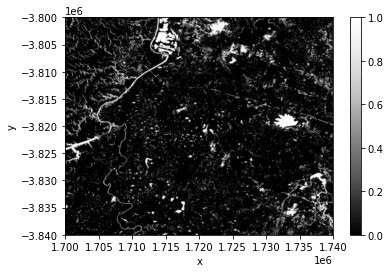

In [86]:
plot_mask(gabrielle_mask)

Then we want to find the best approximation to this using our proxy. "Best" is dependent on the task, so let's optimise for 99% precision, 99% recall, and best accuracy.

In [150]:
proxy_thresholds = np.linspace(0, 100, 20)

In [151]:
proxy_masks = {proxy_name: [tcw_mask & (proxy_values < t) for t in tqdm(proxy_thresholds)] for proxy_name, proxy_values in proxies.items()}

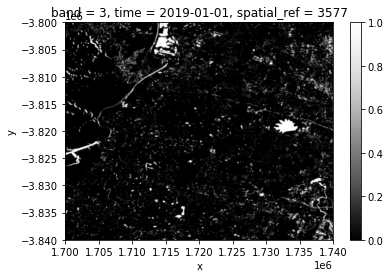

In [153]:
plot_mask(proxy_masks['PV10'][10])

In [154]:
accuracies = {proxy_name: [sklearn.metrics.accuracy_score(gabrielle_mask.values.ravel(), proxy_mask.values.ravel()) for proxy_mask in tqdm(proxy_masks_)]
              for proxy_name, proxy_masks_ in proxy_masks.items()}

In [155]:
precisions = {proxy_name: [sklearn.metrics.precision_score(gabrielle_mask.values.ravel(), proxy_mask.values.ravel()) for proxy_mask in tqdm(proxy_masks_)]
              for proxy_name, proxy_masks_ in proxy_masks.items()}

In [156]:
recalls = {proxy_name: [sklearn.metrics.recall_score(gabrielle_mask.values.ravel(), proxy_mask.values.ravel()) for proxy_mask in tqdm(proxy_masks_)]
           for proxy_name, proxy_masks_ in proxy_masks.items()}

PV50


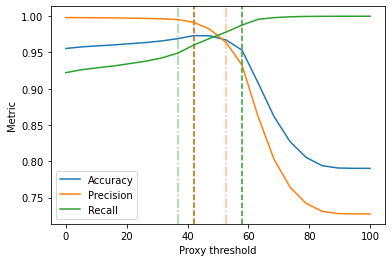

PV10


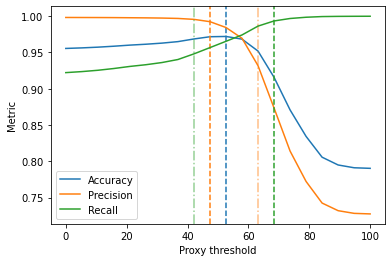

In [160]:
best_acc_idx = {}
precision_99 = {}
precision_95 = {}
recall_99 = {}
recall_95 = {}

for proxy_name in proxy_masks:
    print(proxy_name)
    best_acc_idx[proxy_name] = np.argmax(accuracies[proxy_name])
    precision_99[proxy_name] = abs(np.array(precisions[proxy_name]) - 0.99).argmin()
    precision_95[proxy_name] = abs(np.array(precisions[proxy_name]) - 0.95).argmin()
    recall_99[proxy_name] = abs(np.array(recalls[proxy_name]) - 0.99).argmin()
    recall_95[proxy_name] = abs(np.array(recalls[proxy_name]) - 0.95).argmin()

    plt.plot(proxy_thresholds, accuracies[proxy_name], label='Accuracy')
    plt.axvline(proxy_thresholds[best_acc_idx[proxy_name]], linestyle='--', c='C0')
    plt.plot(proxy_thresholds, precisions[proxy_name], label='Precision')
    plt.axvline(proxy_thresholds[precision_99[proxy_name]], linestyle='--', c='C1')
    plt.axvline(proxy_thresholds[precision_95[proxy_name]], linestyle='-.', c='C1', alpha=0.5)
    plt.plot(proxy_thresholds, recalls[proxy_name], label='Recall')
    plt.axvline(proxy_thresholds[recall_99[proxy_name]], linestyle='--', c='C2')
    plt.axvline(proxy_thresholds[recall_95[proxy_name]], linestyle='-.', c='C2', alpha=0.5)
    plt.xlabel('Proxy threshold')
    plt.ylabel('Metric')
    plt.legend();
    plt.show()

In [161]:
for proxy_name in proxy_masks:
    print(proxy_name, 'best accuracy', max(accuracies[proxy_name]))

PV50 best accuracy 0.973262625
PV10 best accuracy 0.9720299375


PV50


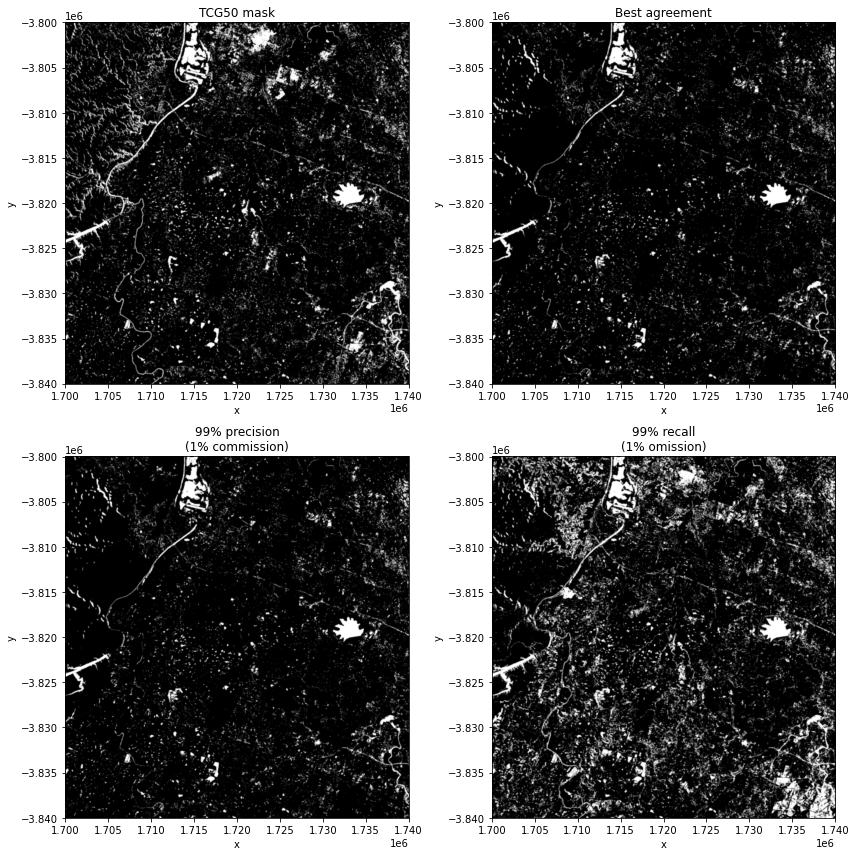

PV10


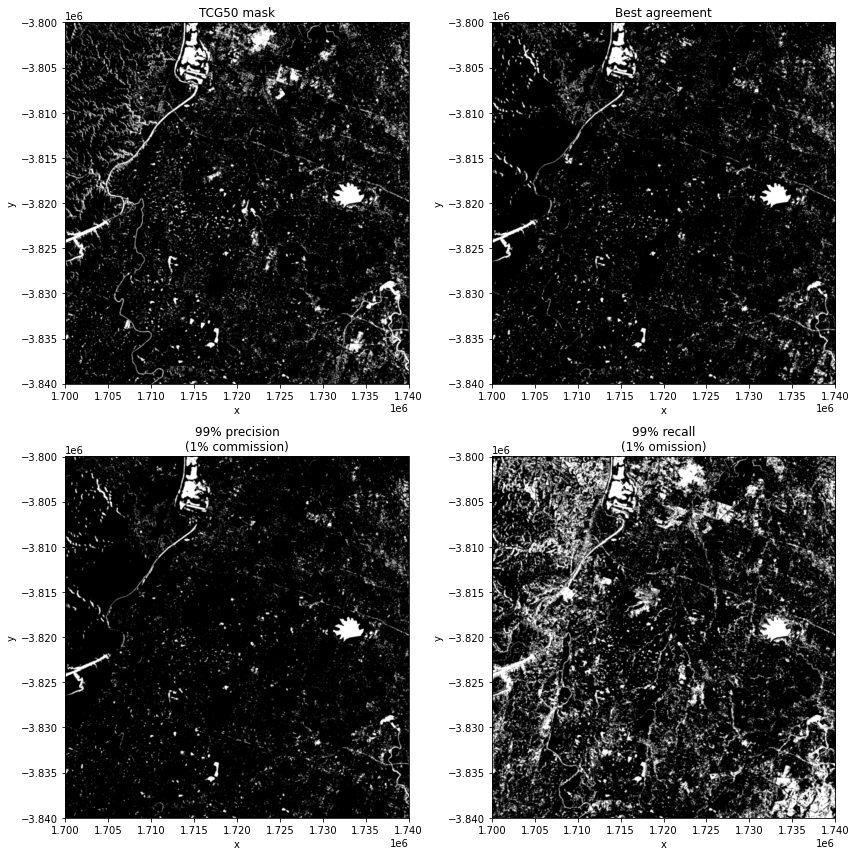

In [164]:
for proxy_name in proxy_masks:
    print(proxy_name)
    fig, ((a, b), (c, d)) = plt.subplots(2, 2, figsize=(12, 12))
    plot_mask(gabrielle_mask, ax=a, add_colorbar=False)
    a.set_title('TCG50 mask')
    plot_mask(proxy_masks[proxy_name][best_acc_idx[proxy_name]], ax=b, add_colorbar=False)
    b.set_title('Best agreement')
    plot_mask(proxy_masks[proxy_name][precision_99[proxy_name]], ax=c, add_colorbar=False)
    c.set_title('99% precision\n(1% commission)')
    plot_mask(proxy_masks[proxy_name][recall_99[proxy_name]], ax=d, add_colorbar=False)
    d.set_title('99% recall\n(1% omission)')
    plt.tight_layout()
    plt.show()

PV50


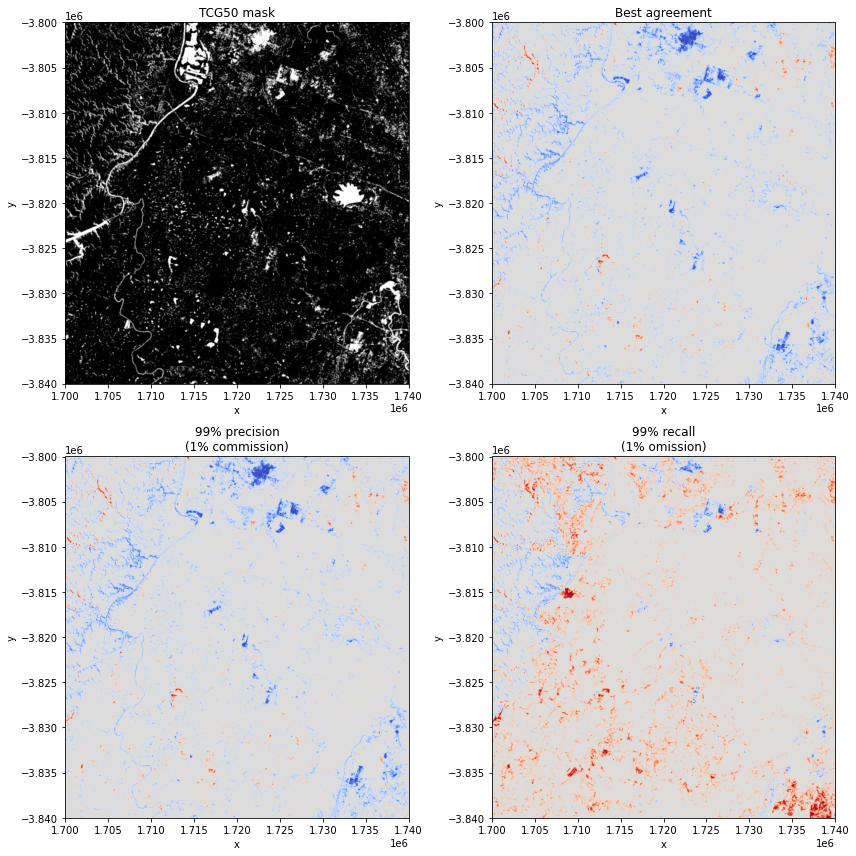

PV10


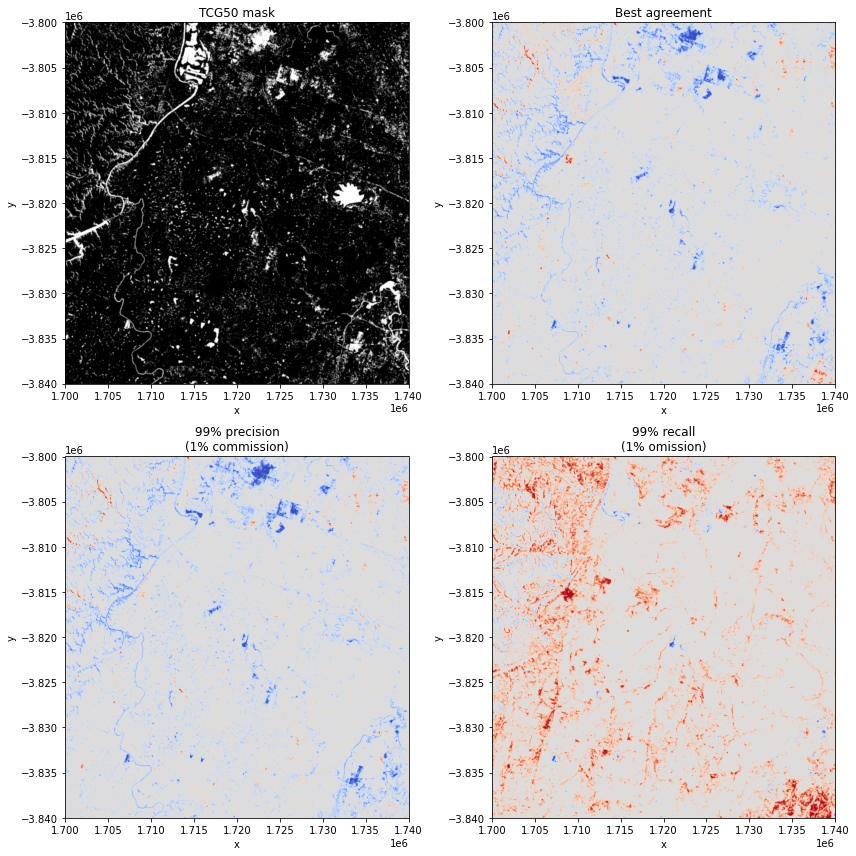

In [169]:
for proxy_name in proxy_masks:
    print(proxy_name)
    fig, ((a, b), (c, d)) = plt.subplots(2, 2, figsize=(12, 12))
    plot_mask(gabrielle_mask, ax=a, add_colorbar=False)
    a.set_title('TCG50 mask')
    plot_mask(proxy_masks[proxy_name][best_acc_idx[proxy_name]] - gabrielle_mask.astype(float), ax=b, add_colorbar=False, cmap='coolwarm')
    b.set_title('Best agreement')
    plot_mask(proxy_masks[proxy_name][precision_99[proxy_name]] - gabrielle_mask.astype(float), ax=c, add_colorbar=False, cmap='coolwarm')
    c.set_title('99% precision\n(1% commission)')
    plot_mask(proxy_masks[proxy_name][recall_99[proxy_name]] - gabrielle_mask.astype(float), ax=d, add_colorbar=False, cmap='coolwarm')
    d.set_title('99% recall\n(1% omission)')
    plt.tight_layout()
    plt.show()